# View CPT Results

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (10, 7)

## Results for 20112012

### Topic word perplexity

In [9]:
import os

def load_perplexity_results(results_dir):
    perplexity_topic = pd.read_csv(os.path.join(results_dir, 'perplexity_topic.csv'), index_col=0)
    perplexity_opinion = pd.read_csv(os.path.join(results_dir, 'perplexity_opinion.csv'), index_col=0)
    
    return perplexity_topic, perplexity_opinion

results_dir = '/home/jvdzwaan/data/dilipad/results/20112012/'
perplexity_topic, perplexity_opinion = load_perplexity_results(results_dir)

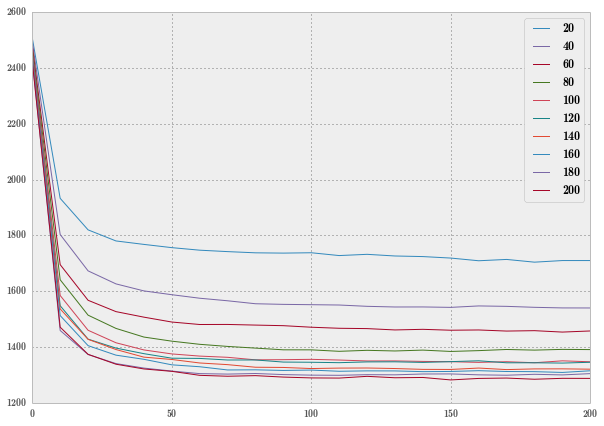

In [10]:
perplexity_topic.plot();

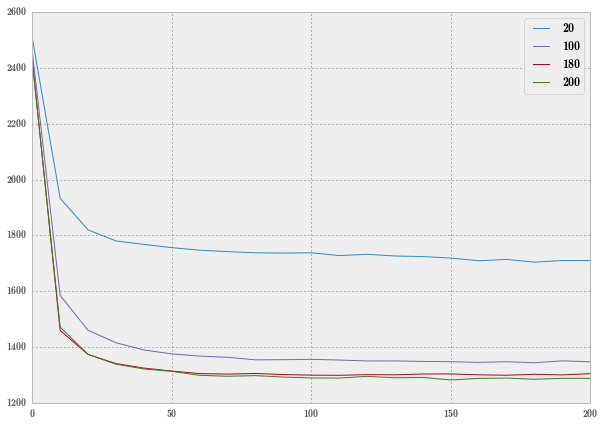

In [11]:
perplexity_topic[['20', '100', '180', '200']].plot();

### Opinion word perplexity

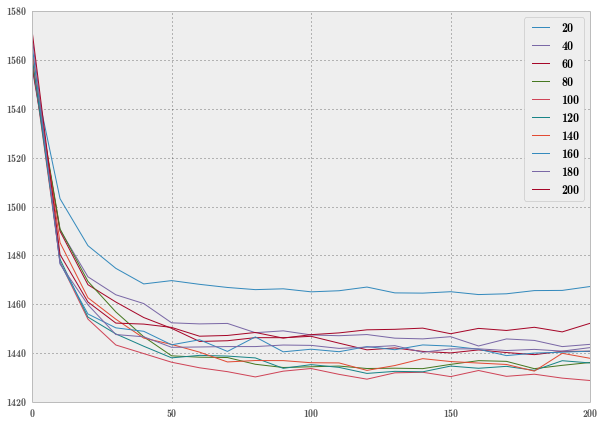

In [12]:
perplexity_opinion.plot();

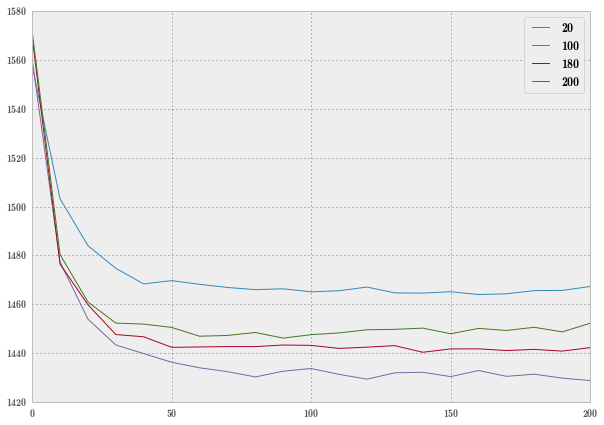

In [13]:
perplexity_opinion[['20', '100', '180', '200']].plot();

Voor topic perplexity is het optimale aantal topics 180. Voor opinion perplexity is het 100.

Wat verder opvalt is dat topic perplexity verder afneemt dan opinion perplexity. Dit heeft vast te maken met dat er veel nutteloze woorden in de opinion woorden zitten (de werkwoorden).

### Results for topics and opinions (nTopics = 100)

In [19]:
# load results
import glob
import os
import re

def load_experiment_results(nTopics, results_dir):

    # document topic matrix (theta)
    theta = pd.read_csv(os.path.join(results_dir, 'theta_{}.csv'.format(nTopics)), index_col=0)

    # phi topic (transposed)
    phi_topic_t = pd.read_csv(os.path.join(results_dir, 'topics_{}.csv'.format(nTopics)), index_col=0, encoding='utf-8')

    # phi opinion (transposed) per perspective
    opinion_files = glob.glob('{}opinions_*.csv'.format(results_dir))
    phis_opinion_t = {}
    for f in opinion_files:
        m = re.match(r'.+opinions_(.+).csv', f)
        name = m.group(1).replace('_{}'.format(nTopics), '')
        phis_opinion_t[name] = pd.read_csv(f, index_col=0, encoding='utf-8')
    return theta, phi_topic_t, phis_opinion_t

In [20]:
results_dir = '/home/jvdzwaan/data/dilipad/results/20112012/'
theta, phi_topic_t, phis_opinion_t = load_experiment_results(100, results_dir)

#### 'Weight' of the most important topic per document

Each topic has a certain weight in the document. We would like to see one (or a few) topics with high weight per document. Below are some basic statistics on the most important topic (highest weight) per document. 

However, because in our case one document consists of the minutes of a single meeting, we might see multiple topics per document. To improve this, we might reconsider making a dataset with a document per ``pm:topic`` instead of a document per document.

In [21]:
def print_topic_weights(theta):
    a = theta.copy().apply(max, axis=1)
    a.sort(ascending=False)

    print 'Mean weight of most important topic: {} (std: {})'.format(a.mean(), a.std())
    print 'Min and max of most important topic: min: {}, max: {}'.format(a.min(), a.max())
    print 'Median weight of most important topic: ', a.median()

print_topic_weights(theta)

Mean weight of most important topic: 0.297432602382 (std: 0.139164873019)
Min and max of most important topic: min: 0.0495798319328, max: 0.709607171999
Median weight of most important topic:  0.278735994398


Line graph of the sorted topic weigths:

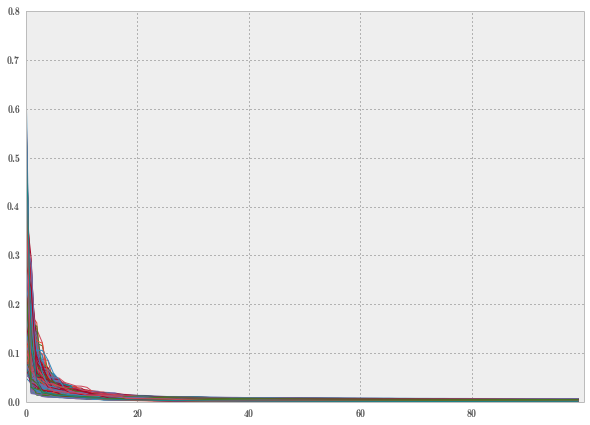

In [22]:
def plot_topic_weights(theta):
    theta.copy().apply(lambda row:sorted(row)[::-1], axis=1).transpose().plot(legend=None);

plot_topic_weights(theta)

#### Number of topics per document

The number of topics per document is calculated by counting the number of topic with weight above a certain threshold. The numer of topics per document should (roughly) be equivalent to the number of ``pm:topic``s per document (however, at the moment we do not have statistics of this).

0      1
1    226
2    379
3    241
4    119
5     35
6     11
dtype: int64


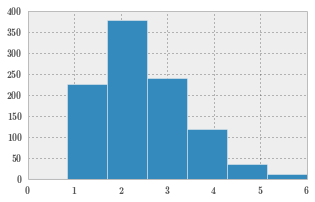

In [23]:
def display_number_of_topics_per_document(theta, threshold=0.05):
    topic_counts = theta.apply(lambda row: np.sum(row > threshold), axis=1)
    print topic_counts.value_counts(sort=False)
    topic_counts.hist(bins=len(topic_counts.value_counts()), figsize=(5,3));

display_number_of_topics_per_document(theta)

#### Topics

In [33]:
def show_topic(t, top=10):
    """Return dataframe containing <top> topic words, weights of topic words and per perspective opinion words and
    weigths of opinion words.
    
    Parameters
        t : str - index of topic number
        top : int - the number of words to store in the dataframe
    
    Returns Pandas DataFrame
    """
    topic = phi_topic_t[t].copy()
    topic.sort(ascending=False)
    topic = topic[0:top]
    df_t = pd.DataFrame(topic)
    df_t.reset_index(level=0, inplace=True)
    df_t.columns = ['topic_{}'.format(t), 'weights_topic_{}'.format(t)]

    dfs = [df_t]

    for p, o in phis_opinion_t.iteritems():
        opinion = o[t].copy()
        opinion.sort(ascending=False)
        opinion = opinion[0:top]
        df_o = pd.DataFrame(opinion)
        df_o.reset_index(level=0, inplace=True)
        df_o.columns = ['opinion_{}_{}'.format(t, p), 'weights_opinion_{}_{}'.format(t, p)]
        dfs.append(df_o)
        
    return pd.concat(dfs, axis=1)

def print_topics(phi_topic_t, phis_opinion_t, nTopics):
    for i in range(nTopics):
        print show_topic(str(i))[['topic_{}'.format(i), 'opinion_{}_Government'.format(i), 'opinion_{}_Opposition'.format(i)]]

In [34]:
print_topics(phi_topic_t, phis_opinion_t, 100)

       topic_0 opinion_0_Government opinion_0_Opposition
0      verdrag       internationaal       internationaal
1   minderheid            nationaal            nationaal
2  goedkeuring          ratificeren          ratificeren
3        staat              sluiten               vallen
4     strafhof               vallen              sluiten
5      werking            dergelijk            bijzonder
6      statuut         ondertekenen         ondertekenen
7     protocol            betekenen              vandaag
8          hof                 kort                zelfs
9       strijd          buitenlands             opzeggen

[10 rows x 3 columns]
                topic_1 opinion_1_Government opinion_1_Opposition
0           bezuiniging           bezuinigen           bezuinigen
1             begroting                  net           financieel
2                 keuze                vorig              betalen
3                budget              aflopen           investeren
4                   

## Results for all years

### Topic word perplexity

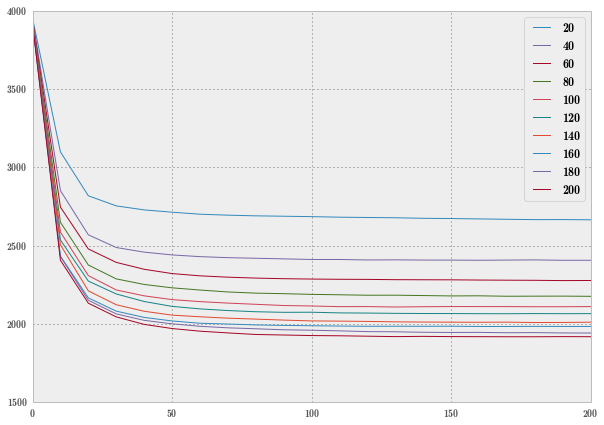

In [14]:
import os

results_dir = '/home/jvdzwaan/data/dilipad/results/all_years/'

perplexity_topic, perplexity_opinion = load_perplexity_results(results_dir)
perplexity_topic.plot();

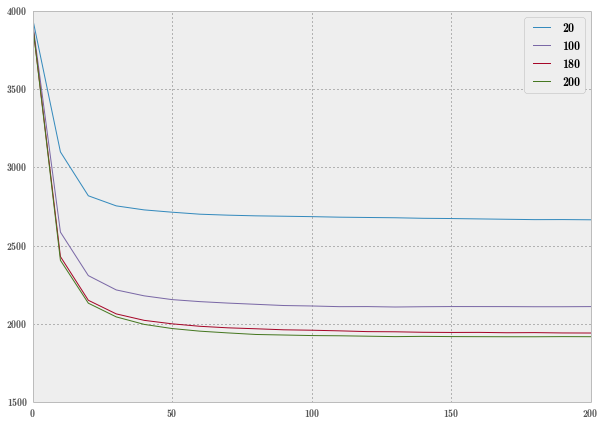

In [15]:
perplexity_topic[['20', '100', '180', '200']].plot();

### Opinion Word Perplexity

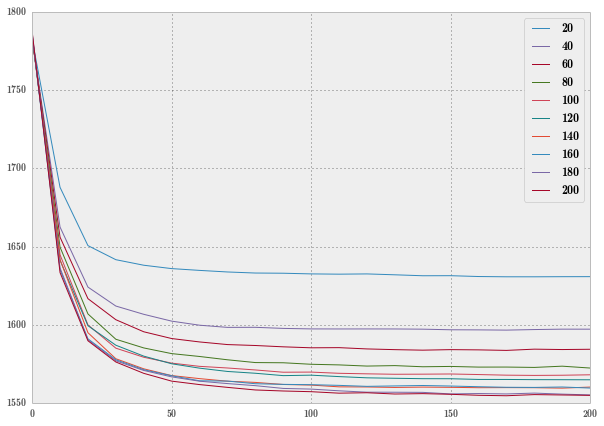

In [16]:
perplexity_opinion.plot();

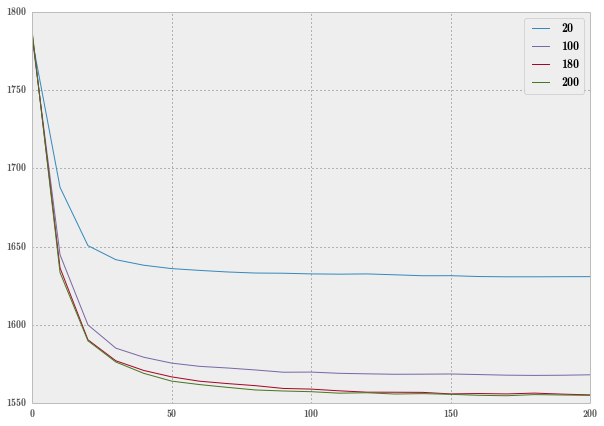

In [17]:
perplexity_opinion[['20', '100', '180', '200']].plot();

Voor deze data set lijkt het optimale aantal topics=200 en opinions=180 te zijn. Voor de volledigheid zouden we CPT moeten doen voor nTopics=220, 240 en 260, maar aangezien 200 en 180 erg dicht bij elkaar liggen, levert dat waarschijnlijk geen betere perplexity resultaten op.

We gaan verder met nTopics=180.

### Results for topics and opinions (nTopics=180)

In [27]:
results_dir = '/home/jvdzwaan/data/dilipad/results/all_years/'
theta, phi_topic_t, phis_opinion_t = load_experiment_results(180, results_dir)

Mean weight of most important topic: 0.244355972551 (std: 0.10926519222)
Min and max of most important topic: min: 0.033619354915, max: 0.697129633195
Median weight of most important topic:  0.228350685168


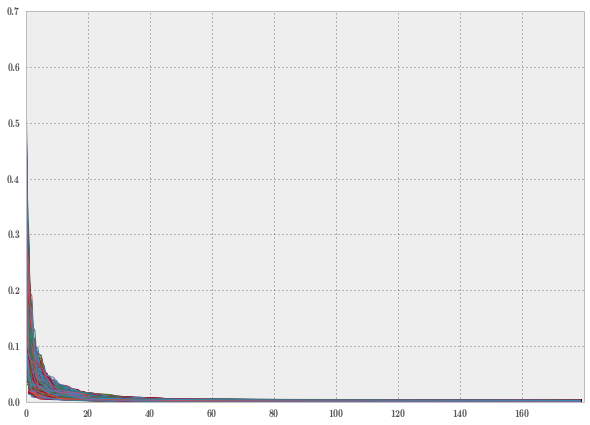

In [29]:
print_topic_weights(theta)
plot_topic_weights(theta)

0      14
8       1
1    1260
2    2878
3    3144
4    1849
5     750
6     177
7      36
dtype: int64


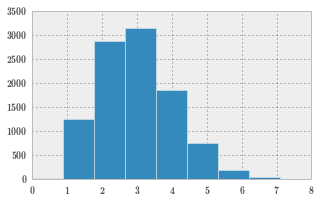

In [30]:
display_number_of_topics_per_document(theta)

In [35]:
print_topics(phi_topic_t, phis_opinion_t, 180)

       topic_0 opinion_0_Government opinion_0_Opposition
0      verdrag       internationaal       internationaal
1   minderheid            nationaal            nationaal
2  goedkeuring          ratificeren          ratificeren
3        staat              sluiten               vallen
4     strafhof               vallen              sluiten
5      werking            dergelijk            bijzonder
6      statuut         ondertekenen         ondertekenen
7     protocol            betekenen              vandaag
8          hof                 kort                zelfs
9       strijd          buitenlands             opzeggen

[10 rows x 3 columns]
                topic_1 opinion_1_Government opinion_1_Opposition
0           bezuiniging           bezuinigen           bezuinigen
1             begroting                  net           financieel
2                 keuze                vorig              betalen
3                budget              aflopen           investeren
4                   